In [1]:
import numpy as np 
import pandas as pd
import re
import string

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv(r'E:\1938_3914_compressed_books.csv\books.csv')
data.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
data.shape

(10000, 23)

In [5]:

ratings = pd.read_csv(r"E:\1938_3914_compressed_ratings.csv\ratings.csv")


In [6]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


# 1. Exploratory Data Analysis

In [7]:
ratings["rating"].describe()

count    981756.000000
mean          3.856534
std           0.983941
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [8]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(ratings.isnull().any()))

No of Nan values in our dataframe :  0


In [9]:
# Find the number of duplicates
dup_bool = ratings.duplicated()
dups= sum(dup_bool)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 1644 duplicate rating entries in the data..


In [10]:
# Drop the duplicates
ratings.drop_duplicates(inplace=True)

In [11]:
# Basic Statistics
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",ratings.shape[0])
print("Total No of Users   :", len(np.unique(ratings.user_id)))
print("Total No of Books  :", len(np.unique(ratings.book_id)))

Total data 
--------------------------------------------------

Total no of ratings : 980112
Total No of Users   : 53424
Total No of Books  : 10000


### 1.1 Distribution of ratings

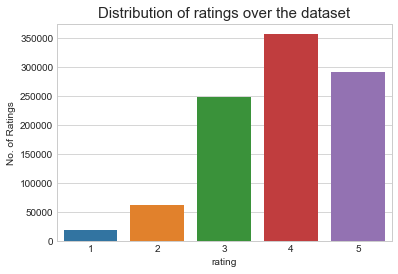

In [12]:
#countplot for the ratings
fig, ax = plt.subplots()
plt.title('Distribution of ratings over the dataset', fontsize=15)
sns.countplot(ratings.rating)
ax.set_ylabel('No. of Ratings')

plt.show()

### 1.2 Top Rated Books

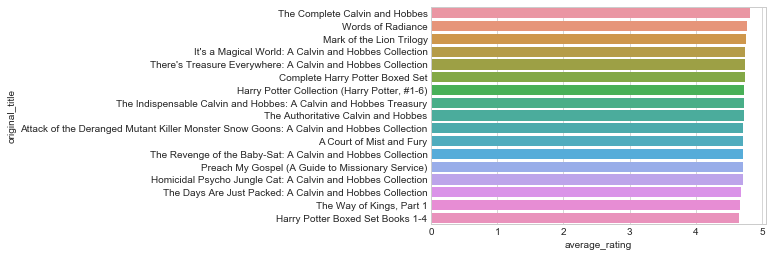

In [13]:
# Bar plot for the Top rated Books
top_rated = data.sort_values('average_rating', ascending=False)
tf_top_rated = top_rated[:20]
sns.barplot(data = tf_top_rated, x="average_rating", y="original_title", 
             orient='h')


### 1.3 Popular Books

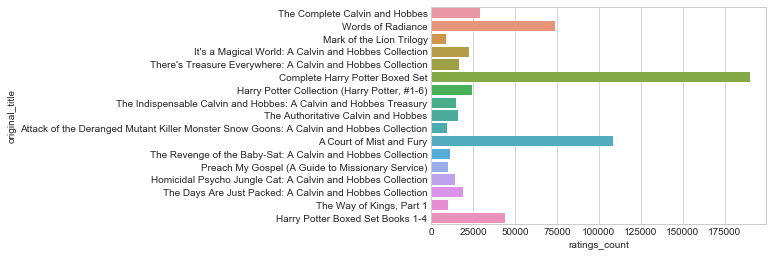

In [14]:
# Bar plot for the Top Popular Books
popular_books = data.sort_values('ratings_count', ascending=False)
tf_top_rated = top_rated[:20]
sns.barplot(data = tf_top_rated, x="ratings_count", y="original_title", 
             orient='h')



# 2. **Content Based Recommendation**

We create a recommendation system based on similar book titles.

In [15]:
books = data[["book_id","original_title"]]

In [16]:
print("No of Nan values in our dataframe : ", sum(books.isnull().any()))

No of Nan values in our dataframe :  1


In [17]:
# Drop the null values
books.dropna(inplace = True)

C:\Users\Niccos Nayak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
# Initialize Tfidf vectorizer & fit into title column
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tf = TfidfVectorizer(ngram_range = (1,2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(books['original_title'])


In [34]:
# Calculate the Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [20]:
# Convert all titles into a Series with book index numbers
titles = books['original_title']
indices = pd.Series(books.index, index = books['original_title']) 

#Function that gets book recommendations based on the cosine similarity score of book titles
def book_recommendations(title, n):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x:x[1], reverse = True)
    sim_scores = sim_scores[1:n+1]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

## 2.1 Results
 We print the books similar to the Harry Potter and the Philosopher's Stone

In [21]:
book_recommendations("Harry Potter and the Philosopher's Stone",3)

3752    Harry Potter Collection (Harry Potter, #1-6)
23               Harry Potter and the Goblet of Fire
22           Harry Potter and the Chamber of Secrets
Name: original_title, dtype: object

# 3. **Collaborative Filtering Recommendation**

## 3.1 Matrix Factorization

In [22]:
# Create a dataframe by merging ratings and books on book_id
data_matrix = pd.merge(ratings,books,on="book_id",how='inner')

In [23]:
data_matrix.head()

,book_id,user_id,rating,original_title
0,1,314,5,Harry Potter and the Half-Blood Prince
1,1,439,3,Harry Potter and the Half-Blood Prince
2,1,588,5,Harry Potter and the Half-Blood Prince
3,1,1169,4,Harry Potter and the Half-Blood Prince
4,1,1185,4,Harry Potter and the Half-Blood Prince


In [24]:
# Drop the duplicates
user_ratings= data_matrix.drop_duplicates(['user_id','original_title'])
user_ratings= data_matrix.drop_duplicates(['user_id','book_id'])

In [26]:
user_ratings.shape

(77754, 4)

In [27]:
# Now create a matrix and fill 0 values
movie_user_rating_pivot = user_ratings.pivot(index = 'user_id', columns = 'original_title', values = 'rating').fillna(0)
movie_user_rating_pivot.head(10)

original_title,,Animal Farm & 1984,Carter Beats the Devil,The Fellowship of the Ring,"めくらやなぎと、眠る女 [Mekurayanagi to, nemuru onna]",'Salem's Lot The Illustrated Edition,'Tis: A Memoir,1421: The Year China Discovered America,1776,31 Songs,...,Ἰλιάς ; Ὀδύσσεια,Ἰστορίαι,Ὀδύσσεια,Ὀρέστεια,…trotzdem Ja zum Leben sagen: Ein Psychologe erlebt das Konzentrationslager,スプートニクの恋人 [Supūtoniku no Koibito],海辺のカフカ [Umibe no Kafuka],砂の女 [Suna no onna],象の消滅 [Zō no shōmetsu],鋼の錬金術師 1
user_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
movie_user_rating_pivot.shape

(28554, 794)

In [29]:
# Transpose of movie_user_rating
X = movie_user_rating_pivot.values.T
X.shape

(794, 28554)

In [30]:
# Now lets fit the model using Truncated SVD
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(794, 12)

In [31]:
# we create a correlation coefficient function for all elements in the matrix
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(794, 794)

## 3.2 Results

In [32]:
movie_title = movie_user_rating_pivot.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Harry Potter and the Philosopher's Stone")

In [33]:
# Creates a list of movies withe correlation >=0.9
corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])

['Harry Potter Collection (Harry Potter, #1-6)',
 "Harry Potter and the Philosopher's Stone",
 'Hatchet',
 "The Hitchhiker's Guide to the Galaxy",
 'The Lord of the Rings',
 'The Lord of the Rings: Weapons and Warfare',
 "The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story"]